# FODS Assignment 1

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
df = pd.read_csv("./data.csv")

In [87]:
df.head()

,X,Y
0,0.987988,5.098368
1,0.719720,2.516654
2,-0.403403,0.337961
3,0.107107,0.737320
4,0.345345,-0.780955


## TASK 1

In [88]:
mean_y = df['Y'].mean()
std_y = df['Y'].std()

### Normalizing 

In [89]:
df['Y'] = (df['Y'] - mean_y) / std_y

In [90]:
df.tail()

,X,Y
995,0.671672,1.174380
996,-0.615616,-0.512541
997,0.259259,0.062779
998,0.119119,-0.392207
999,0.369369,-0.226423


In [91]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_set, test_set = df[:800], df[800:]

In [92]:
print("Training Set:")
print(train_set)
print("\nTesting Set:")
print(test_set)

Training Set:
            X         Y
0   -0.851852 -1.119315
1   -0.853854 -2.033919
2    0.159159  0.660240
3   -0.617618 -0.348264
4   -0.219219  0.315293
..        ...       ...
795 -0.125125  0.023610
796  0.479479 -0.277378
797  0.243243 -0.154319
798 -0.437437  0.403846
799 -0.927928 -1.061514

[800 rows x 2 columns]

Testing Set:
            X         Y
800  0.673674  0.232092
801  0.595596 -0.103215
802  0.485485  1.248083
803 -0.765766 -1.053501
804  0.387387 -0.829054
..        ...       ...
995  0.333333  0.093957
996  0.423423  0.568719
997 -0.803804 -1.053091
998 -0.551552 -1.197638
999 -0.869870 -1.652367

[200 rows x 2 columns]


### Visualizing

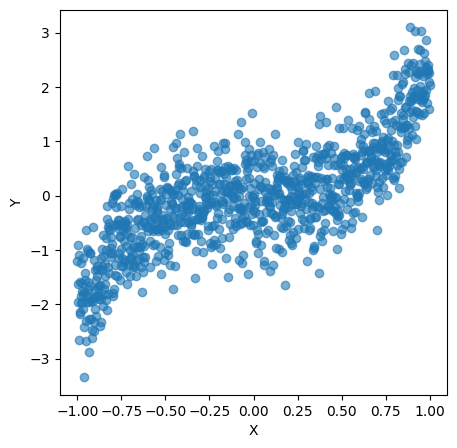

In [93]:
plt.figure(figsize=(5, 5))
scatter = plt.scatter(df['X'], df['Y'], alpha = 0.6)

plt.xlabel('X')
plt.ylabel('Y')

plt.show()

## Task 2

In [94]:
def compute_error(df_train, w, deg):
    error = 0
    for i in range(len(df_train)):
        y = 0
        for j in range(deg + 1):
            y += w[j] * (df_train['X'][i] ** j)
        error += (y - df_train['Y'][i]) ** 2

    return error / 2


In [95]:
def gradient(df_train, w, deg, power, start, end):

    slope = 0
    for i in range(start, end + 1):
        x = np.array([df_train['X'][i] ** j for j in range(deg + 1)])

        y_n = np.dot(w, x) - df_train['Y'][i]
        slope += y_n * (df_train['X'][i] ** power)

    return slope

In [96]:
def gradient_L2(df_train, w, deg, power, start, end, l2_lambda):

    slope = 0
    for i in range(start, end + 1):
        x = np.array([df_train['X'][i] ** j for j in range(deg + 1)])

        y_n = np.dot(w, x) - df_train['Y'][i]
        slope += y_n * (df_train['X'][i] ** power)

    slope += l2_lambda * w[power]

    return slope

In [97]:
def gradient_descent(df_train, w, deg, start, end, gradient):
    
    w_old = w.copy()
    for i in range(deg + 1):
        w[i] -= 0.0001 * gradient(df_train, w_old, deg, i, start, end)

    return w

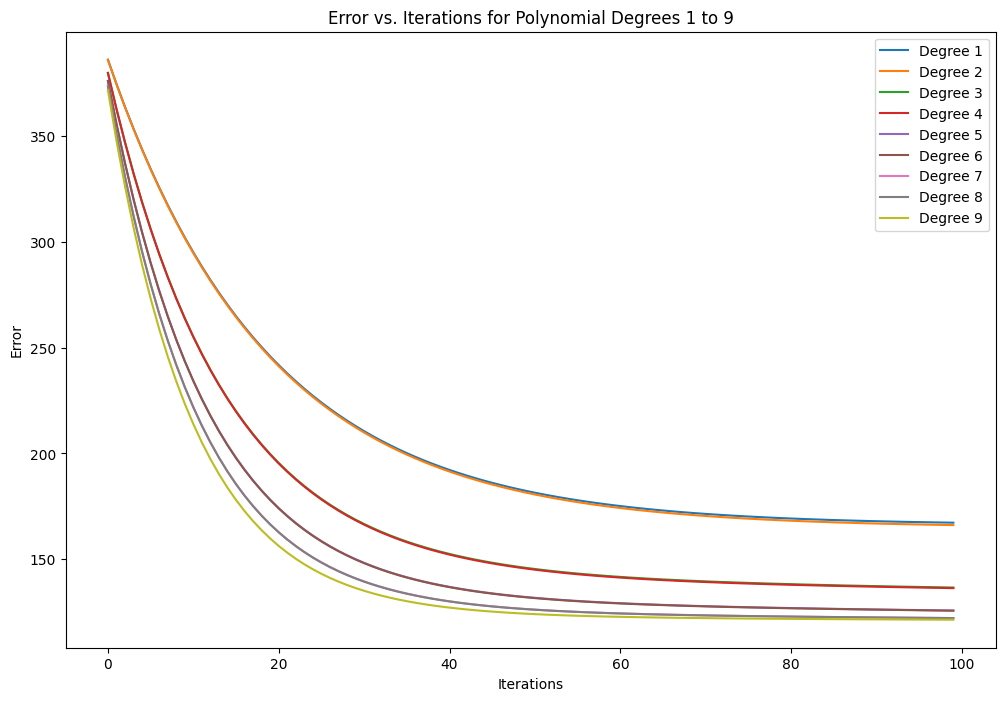

In [98]:
all_errors = {}
batches = 4
multiple = 200

for deg in range(1, 10):
    w = np.zeros(deg + 1)
    errors = []

    for itr in range(100):
        for batch in range(batches):

            w = gradient_descent(
                train_set,
                w,
                deg,
                batch * multiple,
                (batch + 1) * multiple - 1,
                gradient
            )

        error = compute_error(train_set, w, deg)
        errors.append(error)

    all_errors[deg] = errors

plt.figure(figsize=(12, 8))
for deg, errors in all_errors.items():
    plt.plot(errors, label=f"Degree {deg}")

plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("Error vs. Iterations for Polynomial Degrees 1 to 9")
plt.legend()
plt.show()